In [1]:
!pip install kagglehub

In [16]:
from collections import Counter
import os
import random
import yaml

import kagglehub
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import torch
from torchvision import transforms

In [3]:
# Download latest version
path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")

print("Path to dataset files:", path)

100%|██████████| 133M/133M [00:01<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1


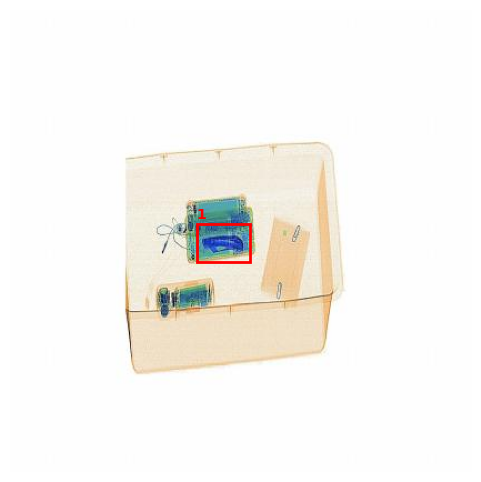

In [4]:
# Definir paths (ajustar a tu ruta base)
base_path = path  # donde kagglehub descargó
images_path = os.path.join(base_path, "train", "images")
labels_path = os.path.join(base_path, "train", "labels")

# Cargar clases desde data.yaml (si querés tener nombres)
with open(os.path.join(base_path, "data.yaml"), "r") as f:
    classes = yaml.safe_load(f)["names"]

# Elegir imagen al azar
img_file = random.choice(os.listdir(images_path))
img_path = os.path.join(images_path, img_file)
label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

# Abrir imagen
img = Image.open(img_path).convert("RGB")
w, h = img.size

# Dibujar imagen
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(img)

# Cargar labels YOLO (clase x_center y_center width height)
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            cls = int(cls)

            # convertir coordenadas YOLO a pixeles
            x_center, y_center = x * w, y * h
            bw, bh = bw * w, bh * h
            x1 = x_center - bw/2
            y1 = y_center - bh/2

            # dibujar rectángulo
            rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2,
                                     edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1-5, classes[cls], color="red", fontsize=10, weight="bold")

plt.axis("off")
plt.show()

## **Distribución de clases**

In [10]:
# Function to load labels and create a DataFrame
def load_labels(label_dir, split_name):
    data = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(label_dir.replace('labels', 'images'), image_file)
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])
                    data.append([split_name, image_path, class_id, x_center_norm, y_center_norm, width_norm, height_norm])
    return pd.DataFrame(data, columns=['split', 'image_path', 'class_id', 'x_center_norm', 'y_center_norm', 'width_norm', 'height_norm'])

# Load data for each split
df_train = load_labels(os.path.join(base_path, "train", "labels"), "train")
df_valid = load_labels(os.path.join(base_path, "valid", "labels"), "valid")
df_test = load_labels(os.path.join(base_path, "test", "labels"), "test")

# Concatenate dataframes
df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

# Add class names (assuming 'classes' list is available from previous cell)
df_all['class_name'] = df_all['class_id'].apply(lambda x: classes[x] if x < len(classes) else f'Unknown_{x}')

print(f"Total de imágenes: {sum(df_all['class_name'].value_counts())}")
# Display class distribution
print("\nClass Distribution:")
display(df_all['class_name'].value_counts().sort_index())

print("\nClass Distribution by Split:")
display(df_all.groupby('split')['class_name'].value_counts().unstack(fill_value=0))

Total de imágenes: 8830

Class Distribution:


,count
class_name,
0,1841
1,1975
2,1041
3,1948
4,2025



Class Distribution by Split:


class_name,0,1,2,3,4
split,,,,,
test,166,193,118,203,203
train,1284,1393,698,1379,1427
valid,391,389,225,366,395


## **Dimensión de imágenes y relación de aspecto**

In [7]:
# Directorios de train y validation
splits = [
    os.path.join(base_path, "train", "images"),
    os.path.join(base_path, "test", "images"),
    os.path.join(base_path, "valid", "images")
]

# Contador de tamaños y canales
sizes_counter = Counter()
channels_counter = Counter()

for split_path in splits:
    for img_name in os.listdir(split_path):
        img_path = os.path.join(split_path, img_name)
        try:
            with Image.open(img_path) as img:
                sizes_counter[img.size] += 1  # (width, height)
                channels_counter[len(img.getbands())] += 1  # nº canales
        except Exception as e:
            print(f"Error al leer {img_path}: {e}")

print("=== Tamaños de imágenes (width x height) ===")
for size, count in sizes_counter.most_common():
    print(f"{size}: {count}")

print("\n=== Número de canales ===")
for ch, count in channels_counter.items():
    label = "Grises" if ch == 1 else "RGB" if ch == 3 else "Otro"
    print(f"{ch} canales ({label}): {count}")

=== Tamaños de imágenes (width x height) ===
(416, 416): 8830

=== Número de canales ===
3 canales (RGB): 8830


La relación de aspecto es 1 porque todas las imágenes son cuadradas (416x416 píxeles).

## **Distribución de bounding boxes**

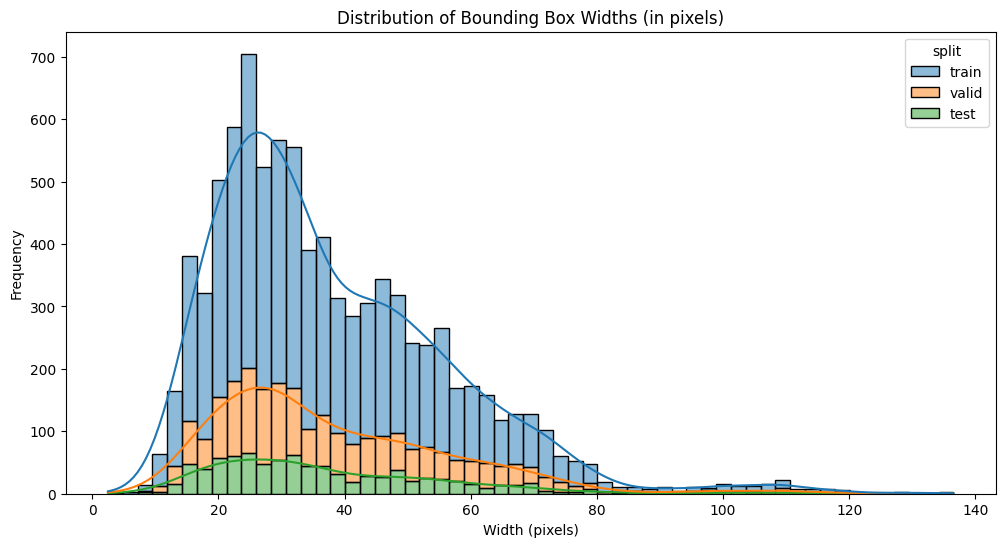

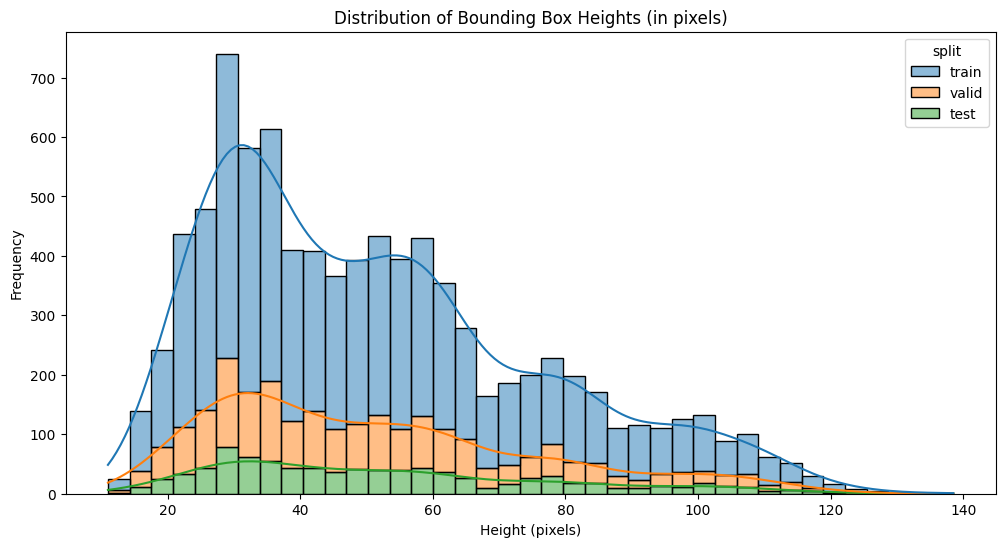

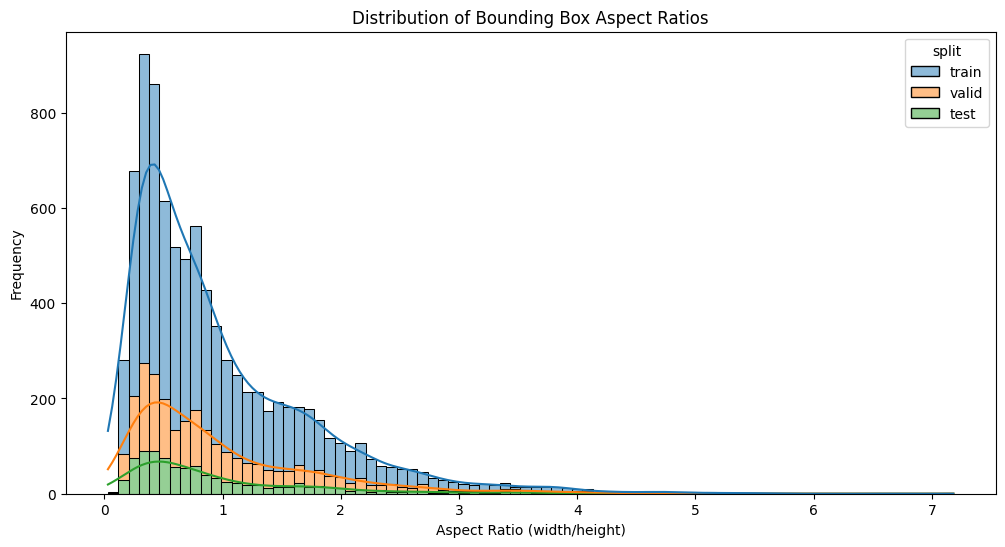

In [14]:
# Analyze bounding box dimensions (width and height)
df_all['width_pixels'] = df_all['width_norm'] * df_all['image_path'].apply(lambda x: Image.open(x).size[0])
df_all['height_pixels'] = df_all['height_norm'] * df_all['image_path'].apply(lambda x: Image.open(x).size[1])

plt.figure(figsize=(12, 6))
sns.histplot(df_all, x='width_pixels', hue='split', kde=True, multiple="stack")
plt.title('Distribution of Bounding Box Widths (in pixels)')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_all, x='height_pixels', hue='split', kde=True, multiple="stack")
plt.title('Distribution of Bounding Box Heights (in pixels)')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

# Analyze bounding box aspect ratio
df_all['aspect_ratio'] = df_all['width_pixels'] / df_all['height_pixels']

plt.figure(figsize=(12, 6))
sns.histplot(df_all, x='aspect_ratio', hue='split', kde=True, multiple="stack")
plt.title('Distribution of Bounding Box Aspect Ratios')
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Frequency')
plt.show()

* Los histogramas de ancho y alto de las bounding boxes en píxeles muestran que la mayoría de las cajas son relativamente pequeñas en comparación con las dimensiones de la imagen completa.
* La distribución de la relación de aspecto de las bounding boxes indica una variedad de formas, con un pico alrededor de 1, lo que sugiere que hay muchos objetos con una relación de aspecto cercana a cuadrada.

## **Calidad de imágenes**

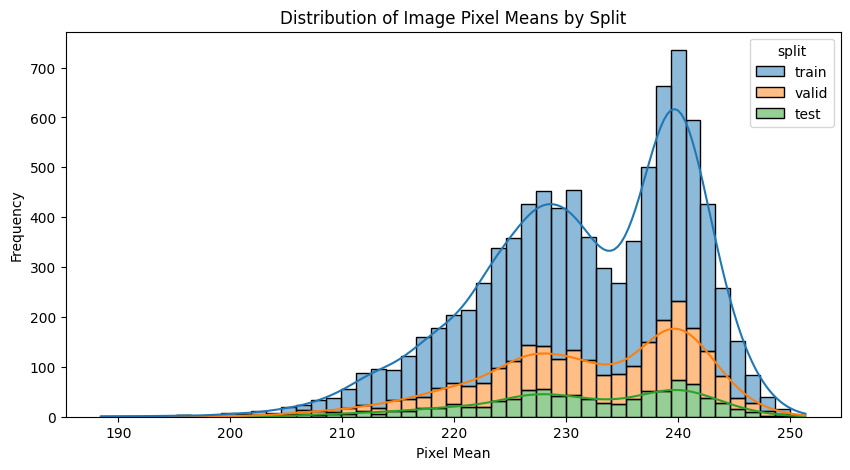

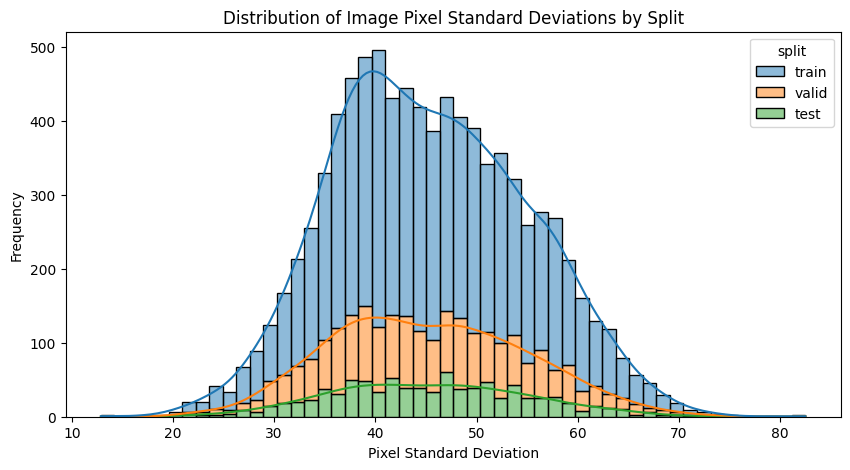

In [17]:
# Calculate mean and standard deviation of pixel values per split
pixel_data = []

for split_name in ["train", "valid", "test"]:
    split_images_path = os.path.join(base_path, split_name, "images")
    for img_file in os.listdir(split_images_path):
        img_path = os.path.join(split_images_path, img_file)
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img)

        pixel_data.append([split_name, np.mean(img_array), np.std(img_array)])

df_pixel_data = pd.DataFrame(pixel_data, columns=['split', 'pixel_mean', 'pixel_std'])

plt.figure(figsize=(10, 5))
sns.histplot(data=df_pixel_data, x='pixel_mean', hue='split', kde=True, multiple="stack")
plt.title('Distribution of Image Pixel Means by Split')
plt.xlabel('Pixel Mean')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_pixel_data, x='pixel_std', hue='split', kde=True, multiple="stack")
plt.title('Distribution of Image Pixel Standard Deviations by Split')
plt.xlabel('Pixel Standard Deviation')
plt.ylabel('Frequency')
plt.show()

Los histogramas de la media y desviación estándar de los píxeles proporcionan información sobre el brillo general y el contraste de las imágenes. La distribución de la media de píxeles muestra dos picos, lo que podría indicar diferentes condiciones de iluminación o tipos de contenido en las imágenes. La desviación estándar de los píxeles sugiere una variabilidad moderada en el contraste

## **Ejemplos de imágenes con anotaciones**

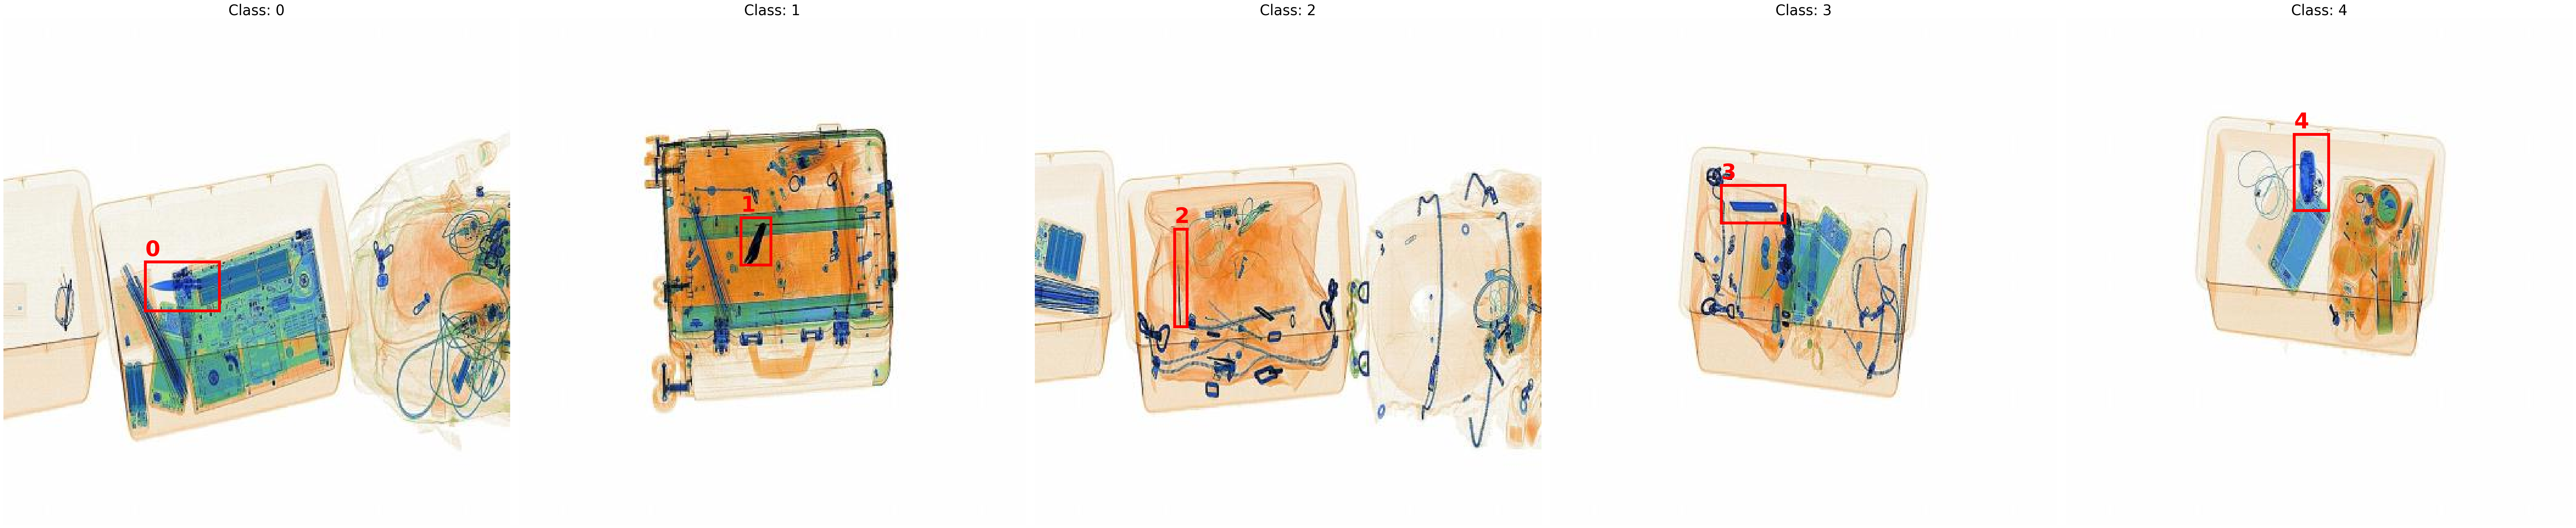

In [28]:
# Display one image for each class with annotations
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get a list of image files
image_files = os.listdir(images_path)

# Find an image for each class
images_by_class = {}
for img_file in image_files:
    img_path = os.path.join(images_path, img_file)
    label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls = int(line.strip().split()[0])
                if cls not in images_by_class:
                    images_by_class[cls] = img_file
                    break # Found an image for this class, move to the next

# Create a figure with subplots for each class found
num_classes_found = len(images_by_class)
fig, axes = plt.subplots(1, num_classes_found, figsize=(15 * num_classes_found, 15))

for i, cls in enumerate(sorted(images_by_class.keys())):
    img_file = images_by_class[cls]
    img_path = os.path.join(images_path, img_file)
    label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

    # Open image
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    # Draw image
    ax = axes[i] if num_classes_found > 1 else axes # Handle single subplot case
    ax.imshow(img)

    # Load and draw YOLO labels for the selected class
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls_id = int(parts[0])
                if cls_id == cls: # Only draw bounding boxes for the current class
                    x, y, bw, bh = map(float, parts[1:])

                    # convert YOLO coordinates to pixels
                    x_center, y_center = x * w, y * h
                    bw, bh = bw * w, bh * h
                    x1 = x_center - bw/2
                    y1 = y_center - bh/2

                    # draw rectangle
                    rect = patches.Rectangle((x1, y1), bw, bh, linewidth=6,
                                             edgecolor="red", facecolor="none")
                    ax.add_patch(rect)
                    ax.text(x1, y1-5, classes[cls_id], color="red", fontsize=45, weight="bold")

    ax.axis("off")
    ax.set_title(f"Class: {classes[cls]}", fontdict={"fontsize": 30})

plt.tight_layout()
plt.show()